Thirafi Najwan Kurniatama
<br>
13520157

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from functools import cmp_to_key
from enum import Enum
import itertools

In [2]:
class PointLoc(Enum):
    UPPER = 0
    LOWER = 1
    INLINE = 2

class MyConvexHull():
    def __init__(self, data, colx, coly):
        self.origdat = data
        self.data = pd.DataFrame(data.data, columns=data.feature_names)
        self.data['target'] = pd.Series(data.target)
        self.colx = colx
        self.coly = coly
        self.color = ['b','r','g', 'cyan', 'orange', 'yellow', 'pink', 'purple', 'brown', 'black', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'limegreen', 'darkgreen', 'darkblue', 'darkred', 'darkcyan', 'darkmagenta', 'darkorange', 'darkgoldenrod', 'darkgray', 'darkorchid', 'darkseagreen', 'deeppink', 'deepskyblue', 'dodgerblue', 'firebrick', 'forestgreen', 'fuchsia', 'gold', 'green', 'hotpink', 'indigo', 'khaki', 'limegreen', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'navy', 'olive', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'peru', 'plum', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'sienna', 'skyblue', 'slateblue', 'slategray', 'springgreen', 'steelblue', 'tan', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'yellowgreen']
    def _locOfPTS(self, point1, point2, tgtpoint):
        det = np.linalg.det([[point1[0], point1[1], 1], [point2[0], point2[1], 1], [tgtpoint[0], tgtpoint[1], 1]])
        if (np.isclose(det, 0)):
            return PointLoc.INLINE
        elif det > 0:
            return PointLoc.UPPER
        else:
            return PointLoc.LOWER

    def _comparator(self, a, b):
        if a[0] < b[0]:
            return -1
        elif a[0] > b[0]:
            return 1
        else:
            if a[1] < b[1]:
                return -1
            elif a[1] > b[1]:
                return 1
            else:
                return 0

    def _dbtp(self, point1, point2):
        return abs(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2))

    def _computeDegree(self, point1, arcpoint, point2):
        return np.arccos((self._dbtp(arcpoint, point1)**2 + self._dbtp(arcpoint, point2)**2 - self._dbtp(point1, point2)**2)/(2*self._dbtp(point1, arcpoint)*self._dbtp(arcpoint, point2)))

    def _computeDistance(self, point1, point2, tgtpoint):
        x_a, y_a = point1
        x_b, y_b = point2
        x_p, y_p = tgtpoint
        return abs((1/2)* abs((x_a - x_p) * (y_b-y_a) - (x_a - x_b)* (y_p - y_a)))

    def _divideWithFarthest(self, setofPoints, point1, point2):
        i = -1
        h = -1
        candidate = []
        for i in range(len(setofPoints)):
            curArea = self._computeDistance(point1, point2, setofPoints[i])
            if np.isclose(curArea, h):
                candidate.append(i)
            elif curArea > h:
                h = curArea
                if (len(candidate) > 0):
                    candidate.pop()
                candidate.append(i)
        degree = -4 # -4 is the small than the smallest degree
        if len(candidate) > 1:
            for posib in candidate:
                curDegree = self._computeDegree(setofPoints[posib], point1, point2)
                if curDegree > degree:
                    degree = curDegree
                    result = posib
            return setofPoints[result]
        else:
            return setofPoints[candidate[0]]
            
    def _findNext(self, setOfPoints, point1, point2, enumparam):
        if len(setOfPoints) > 0:
            setOfDesiredPoint = []
            result = []
            setOfInlinePoint = []
            for point in setOfPoints:
                if self._locOfPTS(point1, point2, point) == enumparam:
                    setOfDesiredPoint.append(point)
                elif self._locOfPTS(point1, point2, point) == PointLoc.INLINE and (not np.array_equal(point, point1) and not np.array_equal(point, point2)):
                    setOfInlinePoint.append(point)
            if len(setOfDesiredPoint) > 0:
                fpoint = self._divideWithFarthest(setOfDesiredPoint, point1, point2)
                result.append(fpoint)
                prop1 = self._findNext(setOfDesiredPoint, point1, fpoint, enumparam)
                prop2 = self._findNext(setOfDesiredPoint, fpoint, point2, enumparam)
                if (len(prop1) > 0):
                    for point in prop1:
                        result.append(point)
                if (len(prop2) > 0):
                    for point in prop2:
                        result.append(point)
            else:
                if (len(setOfInlinePoint) > 0):
                    for point in setOfInlinePoint:
                        result.append(point)
        else:
            result = []
        return result

    def _compute(self, setofPointsUnordered, point1=None, point2=None):
        if (len(setofPointsUnordered) == 0):
            return Exception("Empty set of points")
        elif (len(setofPointsUnordered) > 2):
            setofPointsUnordered = setofPointsUnordered.tolist()
            setofPoints = sorted(setofPointsUnordered, key=cmp_to_key(self._comparator))
            if point1 is None and point2 is None:
                point1 = setofPoints[0]
                point2 = setofPoints[-1]
            setOfUpperPoint = []
            setOfLowerPoint = []
            result = [point1]
            setOfInlinePoint = []
            for point in setofPoints:
                if self._locOfPTS(point1, point2, point) == PointLoc.UPPER:
                    setOfUpperPoint.append(point)
                elif self._locOfPTS(point1, point2, point) == PointLoc.LOWER:
                    setOfLowerPoint.append(point)
                elif not np.array_equal(point, point1) and not np.array_equal(point, point2):
                    setOfInlinePoint.append(point)
            if (len(setOfUpperPoint) > 0):
                prop = self._findNext(setOfUpperPoint, point1, point2, PointLoc.UPPER)
                if len(prop) > 0:
                    prop = sorted(prop, key=cmp_to_key(self._comparator))
                    prop = list(j for j, _ in itertools.groupby(prop))
                    for point in prop:
                        result.append(point)
            result.append(point2)
            if (len(setOfUpperPoint) == 0 or len(setOfLowerPoint) == 0):
                if len(setOfInlinePoint) > 0:
                    result.pop()
                    setOfInlinePoint = sorted(setOfInlinePoint, key=cmp_to_key(self._comparator))
                    setOfInlinePoint = list(j for j, _ in itertools.groupby(setOfInlinePoint))
                    for point in setOfInlinePoint:
                        result.append(point)
                    result.append(point2)
            if (len(setOfLowerPoint) > 0):
                prop = self._findNext(setOfLowerPoint, point1, point2, PointLoc.LOWER)
                if len(prop) > 0:
                    prop = sorted(prop, key=cmp_to_key(self._comparator))
                    prop = list(j for j, _ in itertools.groupby(prop))
                    prop.reverse()
                    for point in prop:
                        result.append(point)
            result.append(point1)
        else:
            result = setofPointsUnordered
        rindices = [setofPointsUnordered.index(i) for i in result]
        pairedidx = [[rindices[i], rindices[i+1]] for i in range(len(rindices)-1)]
        self.pointofdat = pairedidx
        return self.pointofdat

    def show(self):
        plt.clf()
        plt.figure(figsize = (10, 6))
        plt.title(f'{self.origdat.feature_names[self.colx]} vs {self.origdat.feature_names[self.coly]}')
        plt.xlabel(self.origdat.feature_names[self.colx])
        plt.ylabel(self.origdat.feature_names[self.coly])
        for i in range(len(self.origdat.target_names)):
            rawdat = self.data[self.data['target'] == i].iloc[:, [self.colx, self.coly]].values
            plt.scatter(rawdat[:, 0], rawdat[:, 1], label = self.origdat.target_names[i])
            self._compute(rawdat)
            for s in self.pointofdat:
                plt.plot(rawdat[s, 0], rawdat[s, 1], self.color[i])
        plt.legend()
        plt.show()


# Iris Dataset

<Figure size 432x288 with 0 Axes>

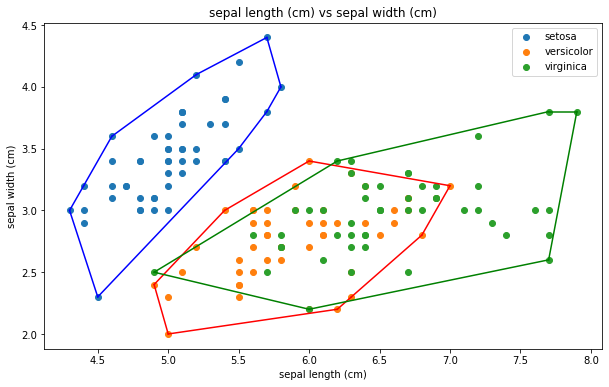

<Figure size 432x288 with 0 Axes>

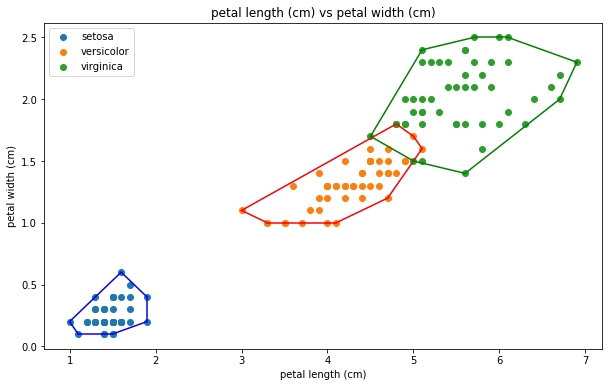

In [3]:
inst = MyConvexHull(datasets.load_iris(), 0, 1)
inst.show()
inst = MyConvexHull(datasets.load_iris(), 2, 3)
inst.show()

# Wine Dataset

<Figure size 432x288 with 0 Axes>

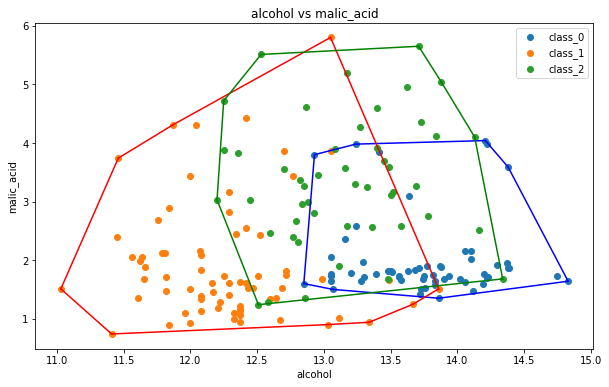

<Figure size 432x288 with 0 Axes>

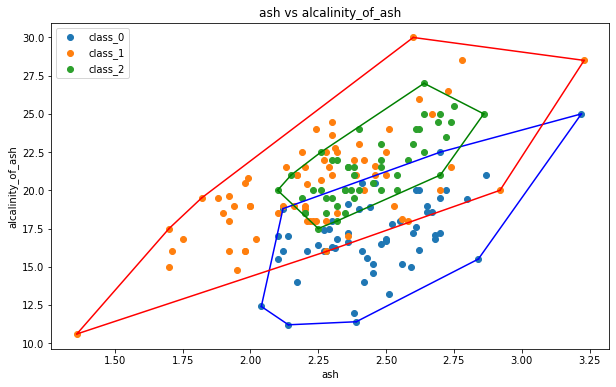

In [4]:
inst = MyConvexHull(datasets.load_wine(), 0, 1)
inst.show()
inst = MyConvexHull(datasets.load_wine(), 2, 3)
inst.show()

# Breast Cancer Dataset

<Figure size 432x288 with 0 Axes>

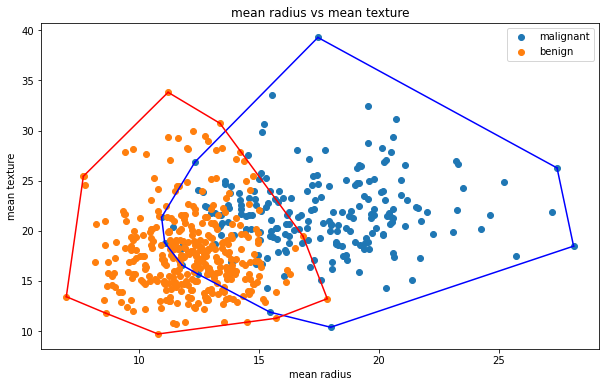

<Figure size 432x288 with 0 Axes>

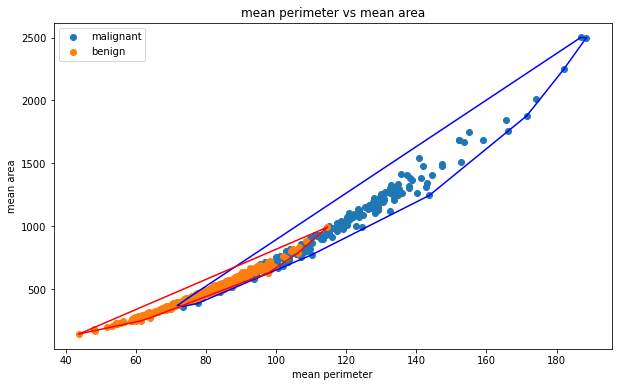

In [5]:
inst = MyConvexHull(datasets.load_breast_cancer(), 0, 1)
inst.show()
inst = MyConvexHull(datasets.load_breast_cancer(), 2, 3)
inst.show()